In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-03 16:52:02,222 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        assert specifics['avg_img']
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
            yt = np.array(y.loc[:, col], dtype=float)
            yp = np.array(y_pred.loc[:, col], dtype=float)
            # Adjusted R squared:
            # https://stackoverflow.com/questions/42033720/python-sklearn-multiple-linear-regression-display-r-squared
            # I think yt.shape[1] is wrong - it should be X.shape[1] so the number of vars to compute df
            # And we don't know this
#             r2_scores['r2_' + col] = 1 - (1-sklm.r2_score(yt, np.nan_to_num(yp)))*(len(yt)-1)/(len(yt)-yt.shape[1]-1)
            r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_params': best_params,
            'best_cost': best_cost,# if 'best_score' not in specifics else specifics['best_score'],
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shapefit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 106 files


In [4]:
subjects = ['12-005', '51-009', '52-001', 'TB']
models = ['A', 'C', 'D2', 'E2', 'F2']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

,adjust_bias,best_cost,best_params,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject
0,False,10.609067,{'rho': 65.2974021486},137.855020,12-005-A-shapefit-swarm_2018-04-01_22-07-02.pi...,../../results/shapefit,A,22,-4.370966,-0.534013,-0.809130,-0.894958,12-005
1,True,10.281662,{'rho': 57.1798278377},120.758101,12-005-A-shapefit-swarm_2018-04-01_22-51-31.pi...,../../results/shapefit,A,22,-3.429565,-0.554617,-0.364652,-1.932829,12-005
2,False,12.089872,{'rho': 57.3038938534},82.775182,12-005-A-shapefit-swarm_2018-04-03_00-13-35.pi...,../../results/shapefit,A,22,-4.417513,-1.289225,-0.327538,-2.055596,12-005
3,True,8.284273,{'rho': 62.7261885026},128.109772,12-005-A-shapefit-swarm_2018-04-03_00-31-50.pi...,../../results/shapefit,A,22,-2.620624,-0.679451,-0.387533,-0.596665,12-005
4,False,11.218461,{'rho': 65.4356636439},124.875039,12-005-A-shapefit-swarm_2018-04-03_06-42-39.pi...,../../results/shapefit,A,22,-4.385011,-0.933562,-0.887193,-1.012696,12-005
5,True,10.031059,{'rho': 65.5812187094},103.570537,12-005-A-shapefit-swarm_2018-04-03_07-17-42.pi...,../../results/shapefit,A,22,-2.617369,-0.652354,-1.222162,-1.539173,12-005
6,False,6.017300,"{'rho': 525.958713594, 'implant_y': -451.12898...",263.436795,12-005-B-shapefit-swarm_2018-04-01_22-35-11.pi...,../../results/shapefit,B,22,-0.220306,-0.438097,-0.710613,-0.648284,12-005
7,True,6.082335,"{'rho': 766.811633219, 'implant_y': 162.501706...",536.132694,12-005-B-shapefit-swarm_2018-04-01_23-14-42.pi...,../../results/shapefit,B,22,-0.008720,-0.454338,-0.744421,-0.874856,12-005
8,False,7.018279,"{'rho': 645.089286598, 'implant_y': -660.31724...",61.078370,12-005-B-shapefit-swarm_2018-04-03_00-23-08.pi...,../../results/shapefit,B,22,-0.798062,-0.718075,-0.932485,-0.569656,12-005
9,True,6.513315,"{'rho': 776.670381759, 'implant_y': -251.16503...",194.634266,12-005-B-shapefit-swarm_2018-04-03_00-38-06.pi...,../../results/shapefit,B,22,0.107847,-0.588186,-1.254766,-0.778210,12-005


# All runs

In [6]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
dropcols = ['filepath', 'exetime', 'n_samples', 'filename']

In [7]:
data.groupby(groupcols)['exetime'].agg(['mean', 'count'])

mean  count
subject model adjust_bias                     
12-005  A     False          115.168414      3
              True           117.479470      3
        B     False          204.319478      3
              True           308.337049      3
        C     False        10564.804656      2
              True          6205.779413      4
        D     False        12660.041918      4
              True          9376.835052      5
51-009  A     False          609.658653      3
              True           384.785437      3
        B     False          299.491796      3
              True           424.402255      3
        C     False        14253.606834      2
              True         15107.493226      3
        D     False        21286.956436      4
              True         14180.780143      2
52-001  A     False          320.777663      3
              True           189.022383      3
        B     False          205.867552      3
              True           446.620208      3
        C     False        14973.048792      2
              True         13336.727006      5
        D     False        10764.841933      7
              True         13636.111145      3
TB      A     False           89.905038      3
              True            73.748509      3
        B     False           89.765512      3
              True            53.049237      2
        C     False         9027.928031      3
              True         15884.563858      4
        D     False        10030.213771      5
              True         13689.822524      4

# The best runs in their respective category

In [8]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=dropcols).groupby(groupcols).max()

Best scores:


best_cost  \
subject model adjust_bias              
12-005  A     False        10.609067   
              True          8.284273   
        B     False         6.017300   
              True          6.082335   
        C     False         6.698470   
              True          4.948181   
        D     False         6.207199   
              True          3.954341   
51-009  A     False        60.637674   
              True         36.780047   
        B     False        24.807309   
              True         15.027173   
        C     False         3.417173   
              True          2.413927   
        D     False         3.124445   
              True          3.676107   
52-001  A     False        11.350649   
              True         14.802569   
        B     False         6.153389   
              True          7.793292   
        C     False         4.802862   
              True          4.474390   
        D     False         4.347180   
              True          4.434205   
TB      A     False        60.391938   
              True         53.552065   
        B     False        13.674720   
              True         19.452858   
        C     False         4.305373   
              True          3.233882   
        D     False         4.679514   
              True          4.069160   

                                                                 best_params  \
subject model adjust_bias                                                      
12-005  A     False                                   {'rho': 65.2974021486}   
              True                                    {'rho': 62.7261885026}   
        B     False        {'rho': 525.958713594, 'implant_y': -451.12898...   
              True         {'rho': 766.811633219, 'implant_y': 162.501706...   
        C     False        {'loc_od_x': 16.1352084816, 'axlambda': 344.12...   
              True         {'loc_od_x': 17.0, 'implant_x': -1336.26807587...   
        D     False        {'loc_od_x': 15.8489433238, 'implant_x': -2000...   
              True         {'loc_od_x': 16.3587832501, 'implant_x': -1868...   
51-009  A     False                                   {'rho': 64.9268946286}   
              True                                    {'rho': 52.9776886251}   
        B     False        {'rho': 248.262542794, 'implant_y': -188.96918...   
              True         {'rho': 173.041837344, 'implant_y': -415.34786...   
        C     False        {'loc_od_x': 17.0, 'axlambda': 2223.19405963, ...   
              True         {'loc_od_x': 16.5859619003, 'implant_x': -654....   
        D     False        {'loc_od_x': 15.3123575201, 'implant_x': -1740...   
              True         {'loc_od_x': 13.0748501999, 'implant_x': -822....   
52-001  A     False                                   {'rho': 67.7638274666}   
              True                                    {'rho': 65.5349563651}   
        B     False        {'rho': 872.365917391, 'implant_y': -143.45272...   
              True         {'rho': 531.093608914, 'implant_y': -103.65058...   
        C     False        {'loc_od_x': 14.9529591615, 'axlambda': 394.38...   
              True         {'loc_od_x': 16.3132640483, 'implant_x': -1866...   
        D     False        {'loc_od_x': 15.8786723258, 'implant_x': -1234...   
              True         {'loc_od_x': 15.084313598, 'axlambda': 1821.87...   
TB      A     False                                   {'rho': 68.9675332754}   
              True                                    {'rho': 68.9495951704}   
        B     False        {'implant_x': 357.601891632, 'implant_y': -276...   
              True         {'rho': 271.343948515, 'implant_y': -69.348370...   
        C     False        {'loc_od_x': 14.896531784, 'implant_x': 134.20...   
              True         {'loc_od_x': 14.7772661239, 'implant_x': 821.6...   
        D     False        {'loc_od_x': 15.4891151385, 'axlambda': 3000.0...   
              True        

# Runs that give sufficiently good results

In [9]:
best_runs = data.loc[best_idx, :]
done_idx = (best_runs['r2_area'] > 0.01) & (best_runs['r2_orientation'] > 0.01)
# done_idx &= (best_runs['r2_eccentricity'] > 0) & (best_runs['r2_compactness'] > 0)

In [10]:
best_runs.loc[done_idx, :].drop(columns=dropcols[:-1]).groupby(groupcols).max()

best_cost  \
subject model adjust_bias              
12-005  C     True          4.948181   
        D     True          3.954341   
51-009  C     True          2.413927   
        D     False         3.124445   

                                                                 best_params  \
subject model adjust_bias                                                      
12-005  C     True         {'loc_od_x': 17.0, 'implant_x': -1336.26807587...   
        D     True         {'loc_od_x': 16.3587832501, 'implant_x': -1868...   
51-009  C     True         {'loc_od_x': 16.5859619003, 'implant_x': -654....   
        D     False        {'loc_od_x': 15.3123575201, 'implant_x': -1740...   

                                                                    filename  \
subject model adjust_bias                                                      
12-005  C     True         12-005-C-shapefit-swarm_2018-04-03_12-15-41.pi...   
        D     True         12-005-D-shapefit-swarm_2018-04-03_17-27-12.pi...   
51-009  C     True         51-009-C-shapefit-swarm_2018-04-02_23-03-08.pi...   
        D     False        51-009-D-shapefit-swarm_2018-04-02_17-07-49.pi...   

                            r2_area  r2_compactness  r2_eccentricity  \
subject model adjust_bias                                              
12-005  C     True         0.172582       -0.323495        -0.909447   
        D     True         0.016823       -0.299697         0.077669   
51-009  C     True         0.400923        0.110059         0.867884   
        D     False        0.202968        0.204977         0.249355   

                           r2_orientation  
subject model adjust_bias                  
12-005  C     True               0.112180  
        D     True               0.250864  
51-009  C     True               0.207207  
        D     False              0.218256

In [11]:
plot_files = best_runs.loc[done_idx, :].reset_index()

In [12]:
y, _, _, _ = pickle.load(open(os.path.join(*plot_files.loc[0, ['filepath', 'filename']]), 'rb'))
columns = y.drop(columns=['electrode', 'image']).columns

# Plot best ones

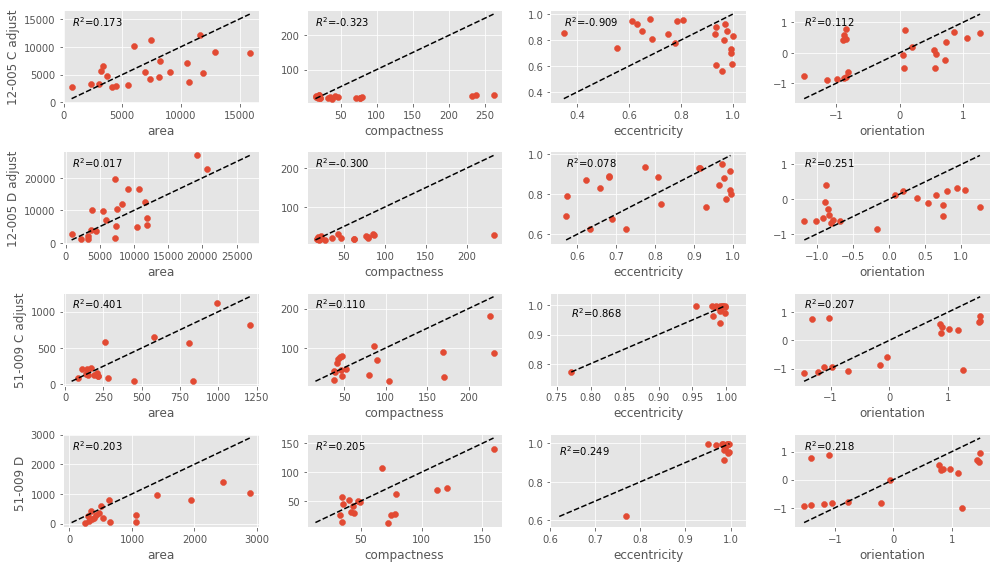

In [13]:
fig, axes = plt.subplots(ncols=len(columns), nrows=len(plot_files), figsize=(14, 2 * len(plot_files)))
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
fig.tight_layout()

In [14]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [15]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [16]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
            df        sum_sq       mean_sq          F    PR(>F)
y_hat      1.0  6.592506e+06  6.592506e+06  26.410507  0.000099
Residual  16.0  3.993869e+06  2.496168e+05        NaN       NaN

compactness
            df        sum_sq      mean_sq          F    PR(>F)
y_hat      1.0   9447.756272  9447.756272  13.047402  0.002339
Residual  16.0  11585.762780   724.110174        NaN       NaN

eccentricity
            df    sum_sq   mean_sq           F        PR(>F)
y_hat      1.0  0.040391  0.040391  108.110871  1.592362e-08
Residual  16.0  0.005978  0.000374         NaN           NaN

orientation
            df     sum_sq   mean_sq         F    PR(>F)
y_hat      1.0   5.527122  5.527122  5.258994  0.035716
Residual  16.0  16.815753  1.050985       NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
